In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#imagine we have a bad detector:
#https://www.youtube.com/watch?v=25ERpsQcsrY
#we do not want o improve the detector, but filter out the noise
#we are calculating the center of one of the cars through out a few frames.

In [ ]:
! wget https://users.itk.ppke.hu/~horan/model04.py
import model04 as Model

--2023-10-04 08:35:19--  https://users.itk.ppke.hu/~horan/model04.py
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433 [text/x-python]
Saving to: ‘model04.py’

model04.py          100%[===================>]     433  --.-KB/s    in 0s      

2023-10-04 08:35:20 (155 MB/s) - ‘model04.py’ saved [433/433]



In [ ]:
M = Model.Model()
Process= M.ProcessCreation(NumPoints=100)
plt.plot(Process)
plt.show()

# **Moving Average**

In [ ]:
'''
you have to iterate through the data taking the average around a window
where the current data point is at the beginning of the window
'''

def MovingAverage(Process,Window):
  Smooth = np.zeros_like(Process)

  for t in range(Window,len(Process)):
    Smooth[t] = np.mean(Process[t-Window:t])

  return Smooth

MAF = MovingAverage(Process,4)

plt.plot(Process,'b')
plt.plot(MAF,'r')
plt.show()

# **Centralized Moving Average**

In [ ]:
'''
you have to iterate through the data taking the average around a window
where the current data point is in the middle of the window
'''

def CentralizedMovingAverage(Process,Window):
    #assert that window size is odd
    assert ((Window-1)%2)== 0, "Window size has to be an odd number."
    Smooth=np.zeros_like(Process)

    HalfWindow = int((Window-1)/2)
    for t in range(HalfWindow,len(Process)-HalfWindow):
      Smooth[t] = np.mean(Process[t-HalfWindow:t+HalfWindow])

    return Smooth

CMAF=CentralizedMovingAverage(Process,5)

plt.plot(Process,'b')
plt.plot(MAF,'r')
plt.plot(CMAF,'g')
plt.show()

# **Exponential Smoothing**

# Single Exponential Smoothing

In [ ]:
'''
Smoothing:
  Smooth(t) = alpha*process(t)+(1-alpha)*Smooth(t-1)

Intilization:
  Smooth(0) = process(0)
'''

def ExpSmo(Process,alpha=0.2):

  Smooth = np.zeros_like(Process)

  Smooth[0] = Process[0]
  for t in range(1,len(Process)):
    Smooth[t] = alpha*Process[t]+(1-alpha)*Smooth[t-1]

  return Smooth

Smo = ExpSmo(Process,0.2)

plt.plot(Process,'b')
plt.plot(Smo,'r')
plt.show()

# **Linear regression**

In [ ]:
"""
*we are trying to fit our data in a simple polynomial (p0+p1*x)

*you have to caculate (N, SumXY, SumX, SumY, SumXX):
                    * N:      length of the process
                    * X:      index of the process
                    * Y:      process
                    * SumXY: sum(X*Y)
                    * SumXX: sum(X*X)
                    * SumX:  sum(X)
                    * SumY:  sum(Y)

*using mean square error we can calculate p0 and p1 as the foloowing:

        *  p1 = (N*SumXY-SumX*SumY)/(N*SumXX- SumX*SumX)
        *  p0 = (SumY-p1*SumX)/N

*Use the equation to calculate the new predicted data points (p0+p1*x)
"""

def LinearRegression(Process):

  N = len(Process)
  x = np.linspace(0,len(Process),len(Process))
  SumXY = (x*Process).sum()
  SumXX = (x*x).sum()
  SumX =  x.sum()
  SumY =  Process.sum()

  p1 = (N*SumXY-SumX*SumY)/(N*SumXX-SumX*SumX)
  p0 = (SumY-p1*SumX)/N

  return p0 , p1 , x

p0, p1, x = LinearRegression(Process)

Line= p0+p1*x

plt.plot(Process,'b')
plt.plot(Line,'r')
plt.show()

# **Non-linear regression**


In [ ]:
X=np.array([1, 2, 4, 5, 8])
Y=np.array([3.2939, 4.2699, 7.1748, 9.3088, 20.5290])
plt.scatter(X,Y)
plt.show()

In [ ]:
"""
We want our data to fit the exponential funtion p0*exp(p1*x)

That means that we have to minimize the loss function (y-(p0*exp(p1*x)))

* intialize P0 and p1

* Loss = [y-p0*exp(p1*x)]

we will calculate the Jacobian matrix (the derivative of each parameter P)

* Jacobian = [P0 derivative, P1 derivartrive] = [-exp(p1*X) , -p0*X*exp(p1*X)]

* P(t1)   = P(t) - Loss @ ((Jacobian.T @ Jacobian)^-1 @ Jacobian.T).T

"""

P = np.asarray([1, 1])

def Loss(Y,X,P):
    L = Y-P[0]*np.exp(P[1]*X)
    return L

def Jacobian(Y,X,P):
  Jac = np.zeros((len(X),len(P)))
  for t in range(len(X)):
    Jac[t] = [-np.exp(P[1]*X[t]) , -P[0]*X[t]*np.exp(P[1]*X[t])]
  return Jac

def NonlinearRegression(X,Y,P,NumIter):
  for it in range(NumIter):
    Jac = Jacobian(Y,X,P)
    L = Loss(Y,X,P)
    P = P - L @ (  np.linalg.inv(Jac.T @ Jac) @ Jac.T).T
    print(P)
  return P

P =  NonlinearRegression(X,Y,P,8)

model=np.zeros_like(Y)

for i,x in enumerate(X):
    model[i]=P[0]*np.exp(P[1]*x)

plt.scatter(X,Y)
plt.plot(X,model,'r')
plt.show()

[0.18167461 0.97815051]
[0.20168151 0.84502119]
[0.3768199 0.6261902]
[0.97879217 0.34678815]
[2.32844381 0.21272371]
[2.42835737 0.28299032]
[2.50103957 0.26403251]
[2.51434331 0.26242899]


# Holt's Exponential Smoothing

In [ ]:
'''
Smoothing:
  Smooth(t) = alpha*process(t)+(1-alpha)*(Smooth(t-1)+Trend(t-1))
  Trend(t)  = beta*(Smooth(t)-Smooth(t-1))+(1-beta)*Trend(t-1)

Intilization:
  Smooth(0) = process(0)
  Smooth(1) = process(1)
  Trend(1)  = Porcess(1)-process(0)

Prediction:
  Smooth(t+1)  = Smooth(t)+Trand(t)
'''

def ExpSmoTre(Process,alpha=0.2,beta=0.95):

  Smooth  = np.zeros_like(Process)
  Trend   = np.zeros_like(Process)

  Smooth[0] = Process[0]
  Smooth[1] = Process[1]
  Trend[1]  = Process[1] - Process[0]

  for i in range(2,len(Process)):
    Smooth[i] = alpha*Process[i]+(1-alpha)*(Smooth[i-1]+Trend[i-1])
    Trend[i]  = beta*(Smooth[i]-Smooth[i-1])+(1-beta)*Trend[i-1]

  return Smooth

SmoTre = ExpSmoTre(Process,0.2,0.35)

plt.plot(Process,'b')
plt.plot(Smo,'r')
plt.plot(SmoTre,'g')
plt.show()

# Winter's Exponential Smoothing

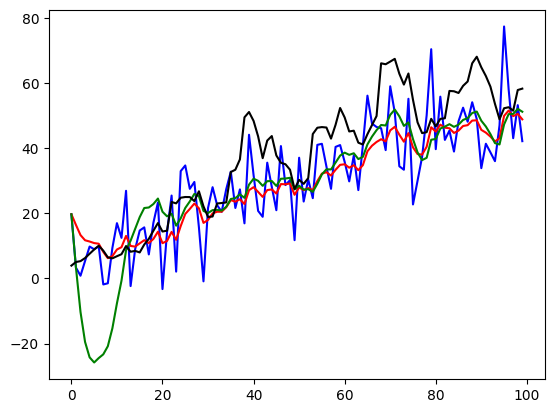

In [ ]:
'''
Smoothing:
  Smooth(t) = (alpha*process(t))/Season(t-S)+(1-alpha)*(Smooth(t-1)+Trend(t-1))
  Trend(t)  = beta*(Smooth(t)-Smooth(t-1))+(1-beta)*Trend(t-1)
  Season(t) = zeta*(X(t)/Smooth(t)) + (1-Zeta)*Season(t-S)
  s         = season length
  N         = process length

Intilization:
  Smooth(0) = process(0)
  Trend(0)  = Sum((Porcess(i+s)-process(i))/s)/s  :  i from 0 to S
  Season(i) = Sum(Process[S*j+i]/A[j])/S :
                  where  j from 0 to N//S
                         A[j] = sum(Process[S*j+i])   : i form 0 to s

Prediction:
  Smooth(t+1)  = (Smooth(t)+Trand(t))/Season(t-S)


*https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm
'''

def ExpSmoTreSea(Process,alpha=0.2,beta=0.95,zeta=0.1, SeaLen = 5):

  Smooth = np.zeros_like(Process)
  Trend  = np.zeros_like(Process)
  Season = np.zeros(SeaLen)

  Smooth[0] = Process[0]

  #Trend intilization
  V = 0
  for i in range(SeaLen):
     V +=  (Process[SeaLen+i]-Process[i])/SeaLen

  Trend[0]  = V/SeaLen

  #Season intilization
  NumSeasons = len(Process)//SeaLen
  A = np.zeros(NumSeasons)
  for j in range(NumSeasons):
    for i in range(SeaLen):
      A[j] += Process[SeaLen*j+i]
    A[j] /= SeaLen

  for i in range(SeaLen):
    for j in range(NumSeasons):
      Season[i] += Process[SeaLen*j+i]/A[j]
    Season[i] /= NumSeasons

  #Smoothing
  for i in range(len(Process)):
    Smooth[i] = alpha*(Process[i]/Season[i%SeaLen])+(1-alpha)*(Smooth[i-1]+Trend[i-1])
    Trend[i]  = beta*(Smooth[i]-Smooth[i-1])+(1-beta)*Trend[i-1]
    Season[i%SeaLen] = zeta*(Process[i]/Smooth[i]) + (1-zeta)*Season[i%SeaLen]

  return Smooth

SmoTreSea = ExpSmoTreSea(Process,0.2,0.35,0.4,15)

plt.plot(Process,'b')
plt.plot(Smo,'r')
plt.plot(SmoTre,'g')
plt.plot(SmoTreSea,'k')
plt.show()